# Alpine Weather Prediction

In [1]:
from os.path import join
import numpy as np
from numpy import *
from pandas import read_feather, DataFrame, melt
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import seaborn

%matplotlib notebook

## Data

The data have already been downloaded and merged in other scripts. Check out [Fuchsberger et al](https://essd.copernicus.org/articles/13/1307/2021/) or see [SOURCES.txt](https://github.com/markmbaum/alpine-weather-prediction/blob/main/SOURCES.txt) in the repository for more information about the data. In summary, we have very high temporal resolution data from 155 weather stations in the Styria region of the Austrian Alps. Each station has measurements every 5 minutes between Jan 2007 and Feb 2022, but I've taken everything up to the end of 2021. The stations are also relatively closely spaced. The whole array occupies an area of about 22 km x 16 km and each station occupies about 2 square km. This means that there will be a lot of similarity accross stations, but they will not be identical.

The meterological variables are

* temperature, T [Celsius]
* relative humidity, RH [%]
* precipitation, P [mm]

along with columns for

* time from the beginning of 2007 [minutes]
* station identification number

I combined all the original data files, converted the timestamps, and saved the data in a single [feather](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_feather.html?highlight=to_feather#pandas.DataFrame.to_feather) file for efficient storage and relatively fast read-in. **The temperature record for each station has already been detrended.** The mean is preserved, but each linear trend is removed. There is no need to detrend the relative humidity or precipitation records.

See the [`scripts`](https://github.com/markmbaum/alpine-weather-prediction/tree/main/scripts) folder in the repository for this intial processing code, which takes advantage of [`multiprocessing`](https://docs.python.org/3/library/multiprocessing.html#module-multiprocessing.pool) pools. There are lots of measurements, but not so many that the dataset can't be handled on a laptop, even if it's a *little* cumbersome. All told, the feather file is about 2.5 GB after converting columns to appropriately memory efficient numeric types.

I would also be happy to share the processed feather file.

In [2]:
df = read_feather(join('data', 'pro', 'wegenernet.feather'))
print(df)
print(df.dtypes)

           station          RH    P         T     time
0                1   96.400002  NaN -2.841776        0
1                1   96.400002  NaN -2.881777        5
2                1   96.400002  0.0 -3.021776       10
3                1   96.400002  0.0 -2.881778       15
4                1   96.400002  0.0 -2.891778       20
...            ...         ...  ...       ...      ...
241426651      155  100.000000  0.0  0.594775  7889735
241426652      155  100.000000  0.0  0.724774  7889740
241426653      155  100.000000  0.0  0.548774  7889745
241426654      155  100.000000  0.0  0.232773  7889750
241426655      155  100.000000  0.0  0.374773  7889755

[241426656 rows x 5 columns]
station      int16
RH         float32
P          float32
T          float32
time         int32
dtype: object


## Objective

There are many things we could do with all this data. To narrow the focus and make things a little more engaging, I invent a totally contrived and somewhat unrealistic weather prediction scenario inspired by the Austrian Alps (kinda... maybe...), where the data come from.

We imagine that we're on a mountaineering trip. We've been acclimatizing at base camp for 5 days and are considering an attempt to the summit of a big mountain. The attempt will take 2 days. On the first day we climb to a final high altitude camp. On the second day we make an early morning push to the summit and then spend the rest of the day descening to base camp.

The weather is the most important factor in our decision to make a summit attempt. We want to know the temperature forecast because it effects climbing conditions up on the snow and ice. Of course, we also want to know if precipitation is expected during the two day window. Climbing in the snow/sleet/rain with low visibility is not safe.

Obviously, in practice, these forecasts would be performed with a big operational weather model. Nevertheless:

**The goal is to forecast**
* temperature time series for the next 2 days 
* total amount of precipitation that is expected over the next 2 days

**using a 5 day window of**
* temperature
* relative humidity
* precipitation

## Data Cleaning and Checking

There are a total of 241,426,656 rows/observations in the whole dataset, or about 1.5 million per station. We can see right at the top of the printed data frame above that at least two of the P (precipitation) values are missing. Let's count the missing values in each column.

In [3]:
df.isnull().sum()

station      0
RH           0
P          612
T            0
time         0
dtype: int64

The precip column is the only one with missing values (612 of them). That's pretty small... only about 0.0002 % of the observations. I'll just fill them with zeros because the modal value is zero. Its usually not raining in the alps.

In [4]:
df['P'].fillna(0.0, inplace=True)

We can also look at descriptive stats and make sure none of the meterological columns have values way out of the expected range.

In [5]:
df[['P','RH','T']].describe()

,P,RH,T
count,2.414267e+08,2.414267e+08,2.414267e+08
mean,8.236807e-03,7.890002e+01,1.051424e+01
std,8.768586e-02,1.680905e+01,8.892224e+00
min,0.000000e+00,5.000000e+00,-2.558642e+01
25%,0.000000e+00,6.736312e+01,3.405927e+00
50%,0.000000e+00,8.413319e+01,1.053603e+01
75%,0.000000e+00,9.202200e+01,1.707317e+01
max,2.155250e+01,1.040000e+02,4.088636e+01


The only potentially suspicious value seems like the maximum relative humidity because it exceeds 100 %. We can investigate.

In [6]:
print('fraction of RH values exceeding 100 %:', sum(df.RH > 100)/len(df))

fraction of RH values exceeding 100 %: 0.00018041504083128251


A very small fraction of RH values are greater than 100 % and this might be worth looking into. It is probably fine, though, and representative of supersaturated air. The peak is only 104 %. We can just leave it alone.

## Initial Data Analysis/Visualization

First, a look at the time series for the 20th station over roughly
* one year
* one month
* 3 days

<IPython.core.display.Javascript object>


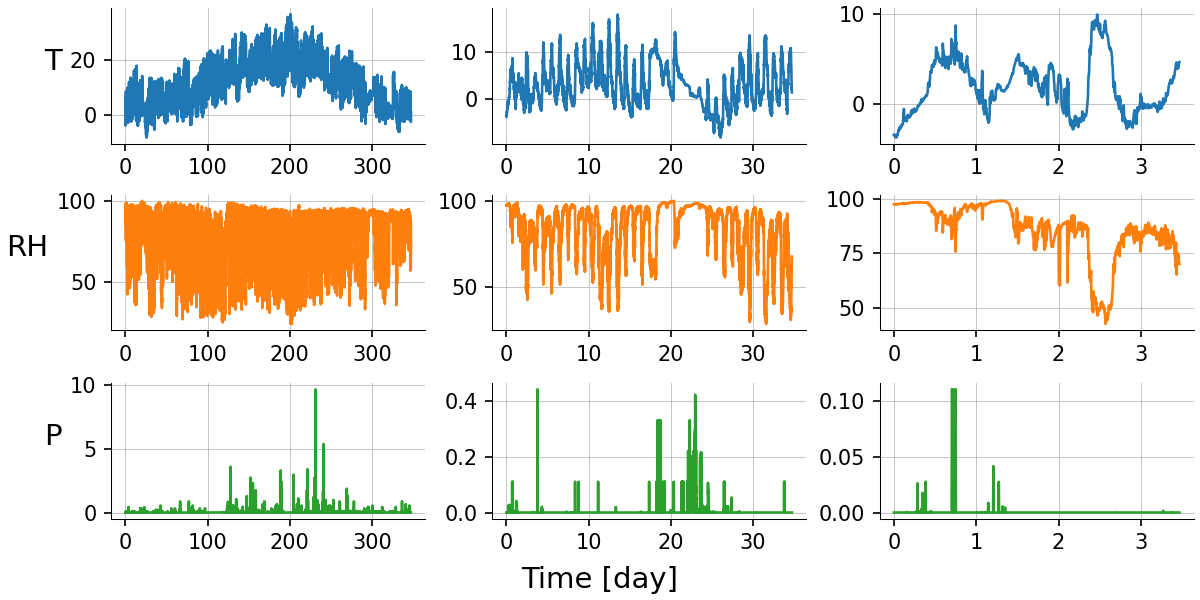

In [7]:
fig, axs = plt.subplots(3, 3, figsize=(8,4), constrained_layout=True)
sl = df[df.station == 20].sort_values('time') #selected station 20 randomly
cols = ['T', 'RH', 'P']
idxs = [100000, 10000, 1000]
for i in range(3):
    axs[i,0].set_ylabel(cols[i], rotation=0, ha='right', fontsize=14)
    for j in range(3):
        x = sl.time.values[:idxs[j]]
        y = sl[cols[i]].values[:idxs[j]]
        axs[i,j].plot(x/(60*24), y, color='C'+str(i))
fig.supxlabel("Time [day]", fontsize=14);

A first peek at the data looks good. In the rightmost column, it looks like `T` and `RH` are a little noisy in some spots.

It seems like there was a pretty significant pair of weather events on either side of day 20 (visible in the middle column of plots). Temperature breaks its usual cycle, RH is elevated for multiple days, and precipitation clusters around the same times. It might be possible to find weather records from the region detailing what happened.

Anyway... We can also have a look at the spectral breakdown of the data. We have every reason to expect strong diurnal and seasonal cycles and it's relatively easy to confirm this. **Reminder:** linear trends for each station's temperature record have [already been removed](https://github.com/markmbaum/alpine-weather-prediction/blob/main/scripts/process_data.py). 

<IPython.core.display.Javascript object>


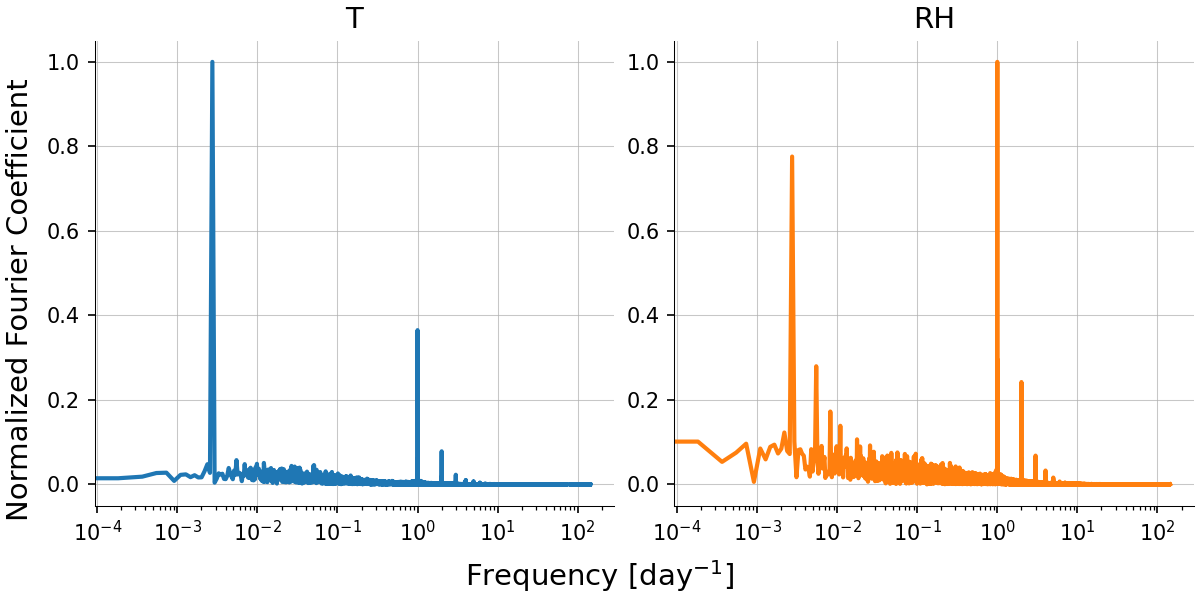

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)
sl = df[df.station == 100] #selected station 100 randomly
for i,(c,ax) in enumerate(zip(['T', 'RH'], axs)):
    y = abs(fft.rfft(sl[c].values - sl[c].mean()))
    x = fft.rfftfreq(len(sl), d=5/(24*60))
    ax.semilogx(x, y/y.max(), color='C'+str(i), linewidth=2)
    ax.set_title(c, fontsize=14)
    #ax.axvline(1, color='k', zorder=-1)
    #ax.axvline(1/365.25, color='k', zorder=-1)
    #ax.set_xticks([1./365.25, 1], labels=['1 year', '1 day'])
fig.supxlabel('Frequency [day$^{-1}$]', fontsize=14)
fig.supylabel('Normalized Fourier Coefficient', fontsize=14);

Temperature and relative humidity have the usual diurnal and seasonal cycles, with spikes at 1 Hz and ~0.003 Hz corresponding to one day and one year. Temperature is more seasonally driven, while RH is more diurnally dependent. This makes sense, considering the first column of the first plot. There are also some peaks on the scale of multi-day variability.

Finally, let's look at the distributions for of a handfull of stations to get a sense of the variability between stations.

In [9]:
stations = array([25, 45, 65, 85, 105, 125, 145])
sl = df.loc[in1d(df.station.values, stations)]

<IPython.core.display.Javascript object>


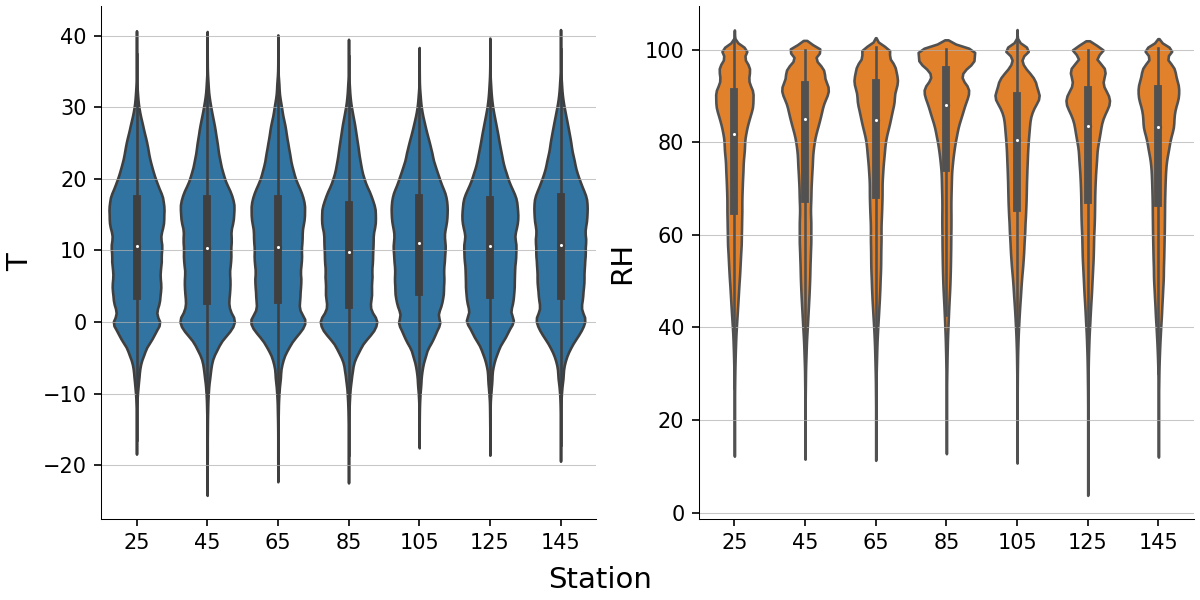

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)
seaborn.violinplot(data=sl, x='station', y='T', color='C0', ax=axs[0])
axs[0].set_ylabel('T', fontsize=14)
seaborn.violinplot(data=sl, x='station', y='RH', color='C1', ax=axs[1])
axs[1].set_ylabel('RH', fontsize=14)
for ax in axs:
    ax.set_xlabel(None)
fig.supxlabel('Station', fontsize=14);

Temperature distributions are quite similar across this sample of stations. Medians all very close to 10 C. There is also a tendency toward 0 C and ~15 C. Looking at the first plot above, these values are similar to the daily low temperatures during the winter and summer, respectively. Maybe that explains it. If interested, we could break it down by season.

Relative humidity is less consistent, but there is still considerable similarity across stations, with tendencies around 90 % and 100 %.

## Temporal Features

The meteorological variables can be used in models without further modification (other than standardization/normalization). However, the time variable will be much more useful if it is directly related to the diurnal and seasonal cycles, which dominate the variability in `T` and `RH`. To do this, we create signals for the "time of day" and "time of year" using sinusoids with day-long and year-long periods. These features will anchor models to the dominant frequencies.

In [11]:
#time of day features
df['tods'] = sin(df.time*2*pi/(60*24))
df['todc'] = cos(df.time*2*pi/(60*24))
#time of year features
df['toys'] = sin(df.time*2*pi/(60*24*365.25))
df['toyc'] = cos(df.time*2*pi/(60*24*365.25))
print(df[['time','tods','todc','toys','toyc']])

              time      tods      todc      toys      toyc
0                0  0.000000  1.000000  0.000000  1.000000
1                5  0.021815  0.999762  0.000060  1.000000
2               10  0.043619  0.999048  0.000119  1.000000
3               15  0.065403  0.997859  0.000179  1.000000
4               20  0.087156  0.996195  0.000239  1.000000
...            ...       ...       ...       ...       ...
241426651  7889735 -0.108867  0.994056  0.004002  0.999992
241426652  7889740 -0.087156  0.996195  0.004062  0.999992
241426653  7889745 -0.065403  0.997859  0.004121  0.999992
241426654  7889750 -0.043619  0.999048  0.004181  0.999991
241426655  7889755 -0.021815  0.999762  0.004241  0.999991

[241426656 rows x 5 columns]


## Input-Label Arrangement

We have to decide exactly what format our inputs and labels will take.

The inputs will be all of the physical variables and the sinusoids, over a perod of 5 days, taken at an appropriate frequency. What frequency should we use? It's not necessary to use measurements every 5 minutes. Real fluctuations in weather happen more slowly, normally over periods of an hour or longer. As such, we will use smoothed hourly inputs, 120 samples total across each 5 day window for 7 features, or 840 individual numbers per input.

One group of outputs/labels will be the temperature forecast. It will be convenient to use the same frequency as the inputs, so we will construct an hourly forecast comprised of 48 points in time. The other output will be the total precipitation expected in the coming two days. This is a single number (a scalar).

We will also start our forecasts at the *beginning* of each day. With hourly records, we could generalize and and make predictions from any hour of day. Because we plan to leave for the summit very early in the morning, though, the forecasts will begin at midnight.

Below we assemble the necessary inputs and labels, standardization each station's records along the way.

In [12]:
standardize = lambda x: (x - x.mean()) / x.std()

def station_inputs_labels(sl):
    #total number of records
    L = len(sl)
    #standardize all columns
    sl = standardize(sl)
    #compute the sum of precip over 2 day intervals
    P = sl['P'].rolling(12*24*2, min_periods=1, center=True).sum().values
    #take the values at beginning of days
    P = P[::12*24]
    #discard the first 5, which are inside label windows only, and last 2
    P = P[5:-2:]
    #restandardize P after sums
    P = standardize(P)
    #select other physical variables
    sm = sl[['T', 'RH', 'P', 'tods', 'todc', 'toys', 'toyc']]
    #smooth them over roughly a half-hourly window
    sm = sm.rolling(7, min_periods=1, center=True).mean()
    #take 7 day windows starting at beginning of each day
    sm = [sm.iloc[i:i+12*24*7:12].values for i in range(0, L-12*24*7, 12*24)]
    #inputs are the first 5 days of these bunches
    inputs = stack([x[:24*5,:] for x in sm])
    #temperature labels are in the last two days of each bunch
    T = stack([x[24*5:,0] for x in sm])
    #make sure everything is uniform type
    return(
        inputs.astype(float32),
        T.astype(float32),
        P.astype(float32)
    )

In [13]:
#create input/labels for each station
inputs, T, P = zip(*[station_inputs_labels(df[df.station == i]) for i in df.station.unique()])

In [14]:
#concatenate everything appropriately into single arrays
inputs = vstack(inputs)
T = vstack(T)
P = hstack(P)
print('input shape:', inputs.shape)
print('T shape:    ', T.shape)
print('P shape:    ', P.shape)

input shape: (837216, 120, 7)
T shape:     (837216, 48)
P shape:     (837216,)


Nice. We have a total of 837,216 input-label pairs for the 2-day temperature forecast and the total precipitation estimate. We can take a look at the precipitation labels to get a sense of their distribution.

<IPython.core.display.Javascript object>


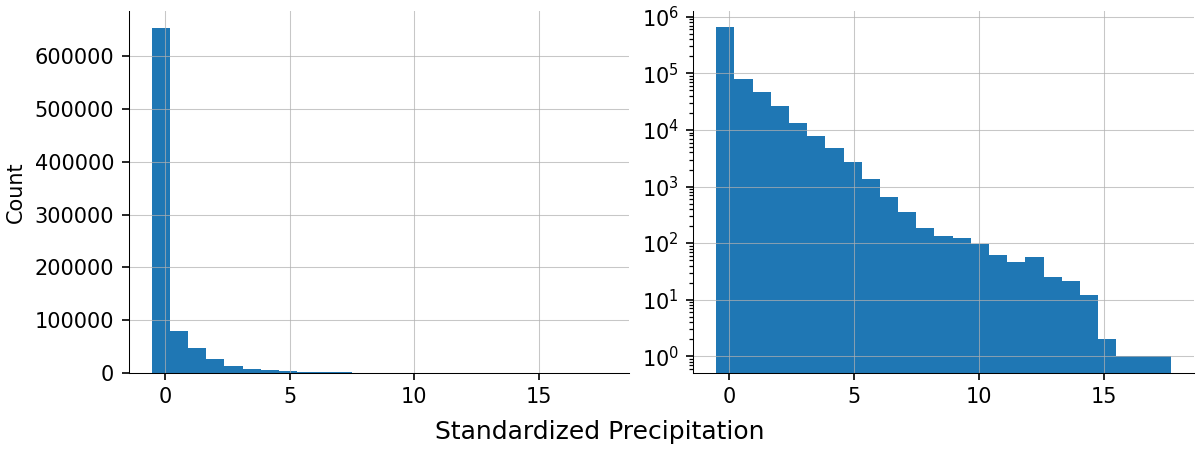

In [15]:
fig, (axa,axb) = plt.subplots(1, 2, figsize=(8,3), constrained_layout=True, sharex=True)
axa.hist(P)
axa.set_ylabel('Count')
axb.hist(P, log=True)
fig.supxlabel("Standardized Precipitation");

On the left, a histogram. On the right, the same histogram with a log scale on the y axis.

Precipitation labels are very strongly skewed toward lower values (it's usually not raining). This is to be expected, but is something to keep in mind for the modeling. Instead of predicting a continuous value for the expected precipitation, it might be better to predict whether precipitation will exceed a certain tolerance, a binary classification problem. We will see.

Now... the actual modeling.

## Forecasting

In [17]:
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *

A short function for inserting loss values into a little logging data frame.

In [18]:
def log_losses(dflog, model_name, val_loss, test_loss):
    i = len(dflog)
    names = list(dflog.model.values)
    if model_name in names:
        i = names.index(model_name)
    dflog.at[i,'model'] = model_name
    dflog.at[i,'val_loss'] = val_loss
    dflog.at[i,'test_loss'] = test_loss
    return(None)

A couple of functions for streamlining model compilation and training, with MSE loss and the Adam optimizer by default.

In [19]:
def compile_model(model, loss=MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[]):
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=metrics
    )
    return(None)

def fit_model(model, train, validate, test, max_epochs=6, verbose='auto'):
    history = model.fit(
        train,
        epochs=max_epochs,
        validation_data=validate,
        callbacks=[
            #cut training off if/when validation loss plateaus
            callbacks.EarlyStopping(
                monitor='val_loss',
                patience=2,
                mode='min'
            ),
            #also 
        ],
        verbose=verbose
    )
    test_metrics = model.evaluate(test, verbose=False)
    #print("\ntest set metrics:", test_metrics)
    return(history, test_metrics)

def compile_fit_log(model, name, train, validate, test, dflog, max_epochs=6, verbose='auto'):
    compile_model(model)
    history, test_loss = fit_model(model, train, validate, test, max_epochs, verbose)
    log_losses(dflog, name, history.history['val_loss'][-1], test_loss)
    return(history, test_loss)

### Temperature Forecasting

In [20]:
#tensorize and shuffle the temperature data set
ds = Dataset.from_tensor_slices((inputs, T)).shuffle(T.shape[0])

In [21]:
#training, validation, and test splits
n = len(P)//10
tr = ds.take(7*n).batch(64)
va = ds.skip(7*n).take(2*n).batch(64)
te = ds.skip(9*n).batch(64)

In [22]:
#store a group of input-label pairs for plotting consistently across models
cached = [(tf.expand_dims(x,0), tf.expand_dims(y,0)) for x,y in ds.take(10)]

In [23]:
#start a small data frame for comparing models
dflog = DataFrame(columns=['model', 'val_loss', 'test_loss'])

In [24]:
#inspect the element shapes for reference
print(tr.element_spec)

(TensorSpec(shape=(None, 120, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 48), dtype=tf.float32, name=None))


In [25]:
#for plotting a sample of inputs, labels, and predictions with residuals
def plot_temperature(model, nplots=4):
    fig, axs = plt.subplots(
        nplots, 2,
        figsize=(8,1.5*nplots),
        constrained_layout=True,
        gridspec_kw=dict(width_ratios=[0.8,0.2])
    )
    t = linspace(0, 7, 169)
    for i in range(nplots):
        x, y = cached[i]
        labels = y[0,:]
        predictions = model(x)[0,:]
        #inputs & comparison
        axs[i,0].plot(t[:120], x[0,:,0], "C0", label="inputs")
        axs[i,0].plot(t[121:169], labels, "C1", alpha=0.75, label="labels")
        axs[i,0].plot(t[121:169], predictions, "--", color="C3", label="predictions")
        #residual
        axs[i,1].plot(t[121:169], predictions - labels, color='C3')
        axs[i,1].axhline(0, color='k')
        axs[i,1].set_ylim(-1.2, 1.2)
    axs[0,0].legend(
        loc='upper center',
        bbox_to_anchor=(0.5, 1.2),
        ncol=3
    )
    axs[0,1].set_title('Residuals')
    fig.supylabel("Standardized Temperature")
    fig.supxlabel("Time [days]")
    return(fig, axs)

#### Linear Model

It's instructive to have first order model results available for comparison.

In [26]:
linear = Sequential([Flatten(), Dense(48)])

In [27]:
compile_fit_log(linear, 'linear', tr, va, te, dflog, 10, 0);

<IPython.core.display.Javascript object>


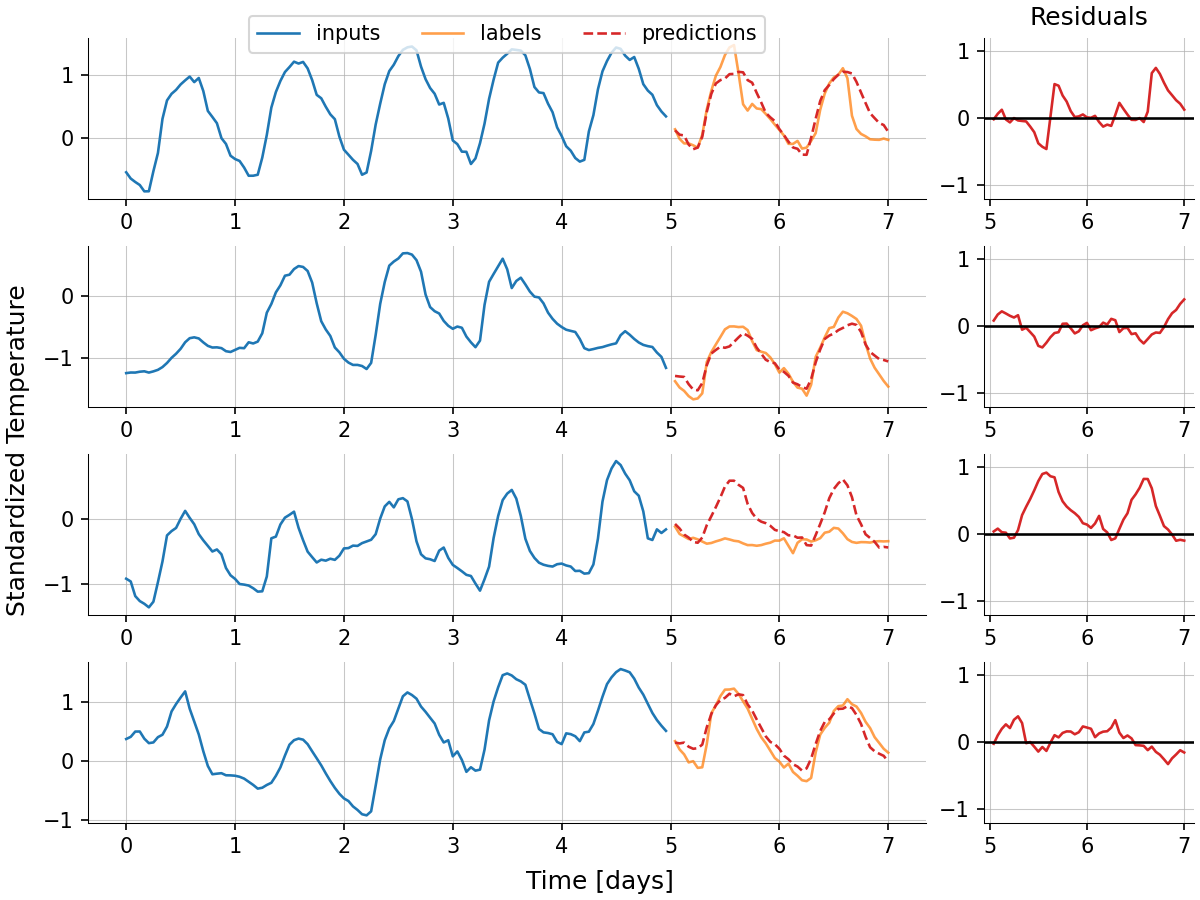

In [28]:
plot_temperature(linear);

#### Small Dense Nonlinear Model

In [29]:
dense_small = Sequential([
    Flatten(),
    Dense(96, activation='swish'),
    Dense(96, activation='swish'),
    Dense(48),
])

In [30]:
compile_fit_log(dense_small, 'dense_small', tr, va, te, dflog, 10, 0);

#### Larger Dense Nonlinear Model

In [31]:
dense_large = Sequential([
    Flatten(),
    Dense(128, activation='swish'),
    Dense(128, activation='swish'),
    Dense(128, activation='swish'),
    Dense(48),
])

In [32]:
compile_fit_log(dense_large, 'dense_large', tr, va, te, dflog, 10, 0);

#### Convolutional Model

In [33]:
conv = Sequential([
    Conv1D(32, 3, activation='swish'),
    MaxPool1D(2),
    Conv1D(64, 3, activation='swish'),
    MaxPool1D(2),
    Conv1D(128, 3, activation='swish'),
    MaxPool1D(2),
    Flatten(),
    Dense(256, activation='swish'),
    Dense(48)
])

In [34]:
compile_fit_log(conv, 'conv', tr, va, te, dflog, 10, 0);

<IPython.core.display.Javascript object>


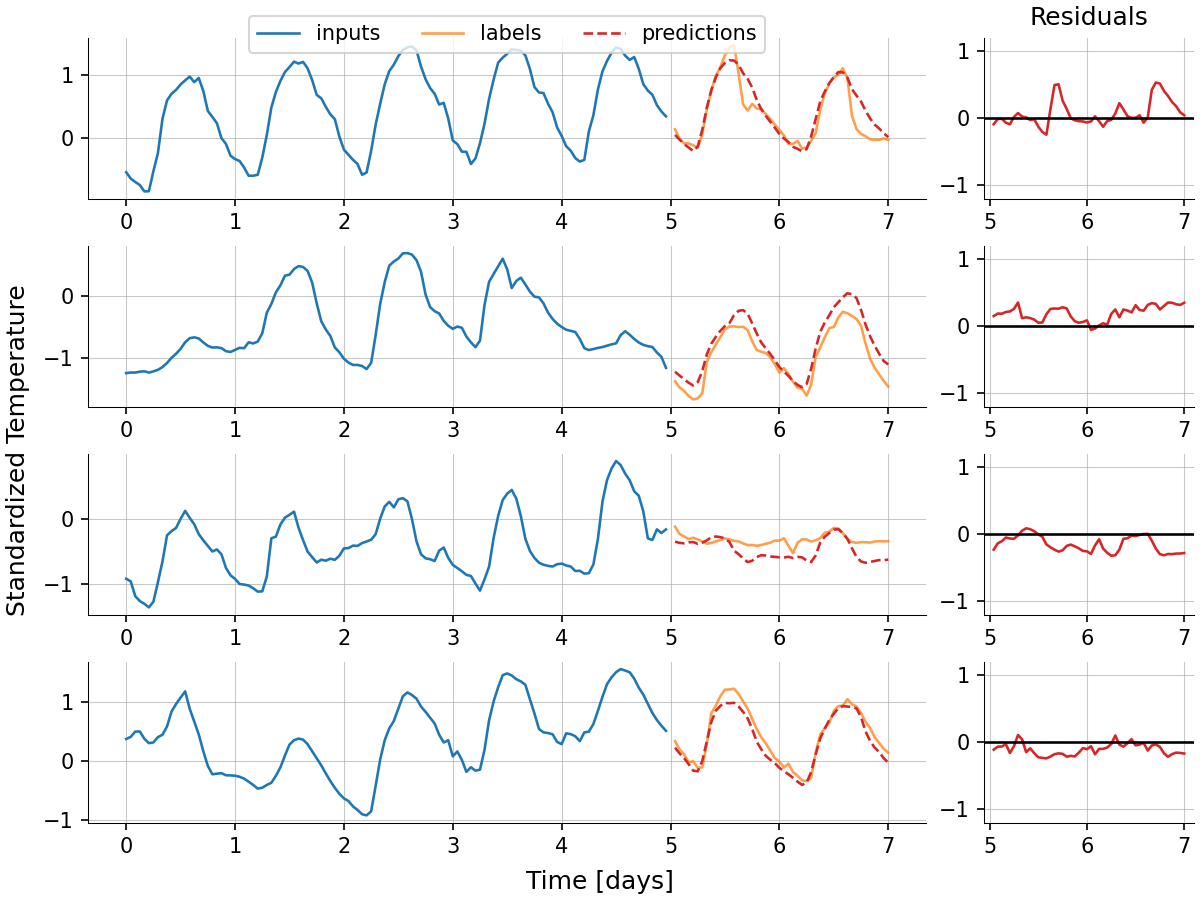

In [35]:
plot_temperature(conv);

Note, in the plot above, that the third forecast is markedly improved compared to the linear model. The shape of the first forecase is also captured much better. Below we compare losses for each of these 4 models.

#### Model Comparison

<IPython.core.display.Javascript object>


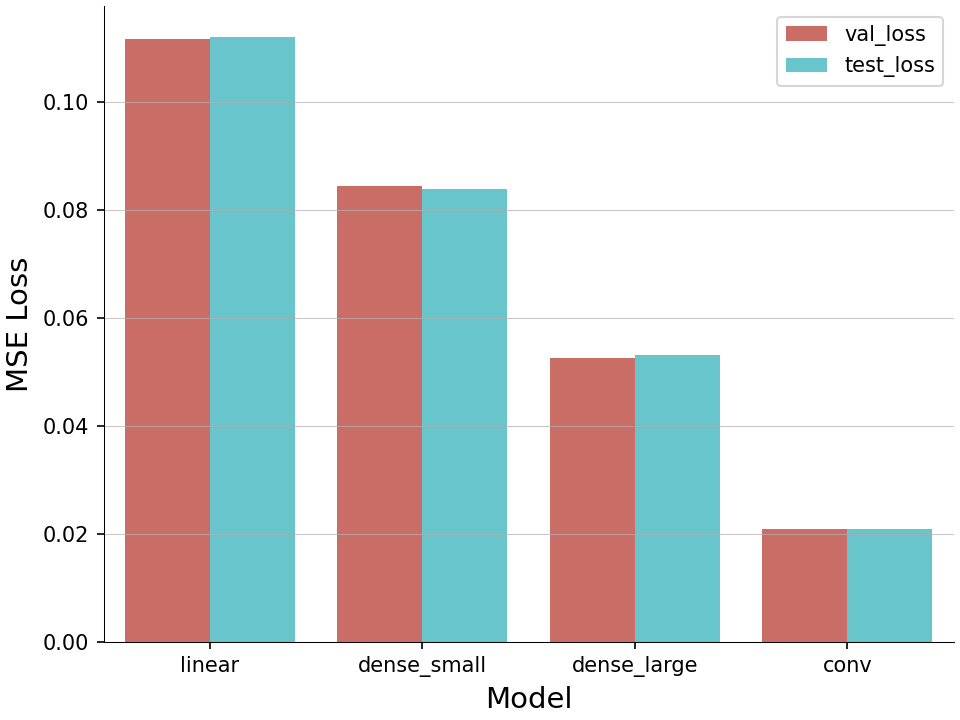

In [36]:
fig, ax = plt.subplots(1, 1, constrained_layout=True)
ax = seaborn.barplot(
    data=melt(dflog, 'model', ['val_loss','test_loss']),
    x='model',
    y='value',
    hue='variable',
    palette='hls'
)
ax.set_xlabel('Model', fontsize=14)
ax.set_ylabel('MSE Loss', fontsize=14)
ax.get_legend().set_title(None);

Nice! The test loss is almost identical to the validation loss for each model, indicating the models are not at risk of overfitting.

The convolutional model also clearly wins. This is a pretty classic set of results. The forecasts are improved by adding nonlinear capacity, then expanding the model, then using convolution to capture relationships within adjacent portions of the inputs.

### Precipitation Forecasting

Now we build a separate model for the precipitation forecast. In principle, it's also possible to incorporate the temperature and precipitation forcasts into a single model, but I'd like to evaluate the models independently.

Instead of training a several different models, I will start with a single dense model and see how it performs.

In [37]:
#tensorize and shuffle the temperature data set
ds = Dataset.from_tensor_slices((inputs, P)).shuffle(len(P))

In [38]:
#inspect the element shapes for reference
print(tr.element_spec)

(TensorSpec(shape=(None, 120, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 48), dtype=tf.float32, name=None))


In [39]:
#training, validation, and test splits
n = len(P)//10
tr = ds.take(7*n).batch(64)
va = ds.skip(7*n).take(2*n).batch(64)
te = ds.skip(9*n).batch(64)

#### Dense Model

In [40]:
dense = Sequential([
    Flatten(),
    Dense(128, activation='swish'),
    Dense(128, activation='swish'),
    Dense(128, activation='swish'),
    Dense(1),
])

In [41]:
compile_model(dense)

In [42]:
history, test_loss = fit_model(dense, tr, va, te, 10, 0);
print('test loss = ', test_loss)

test loss =  0.20643627643585205


A test loss of 0.2 is not particularly good. Let's plot the predictions against the observations using a `kdeplot`.

<IPython.core.display.Javascript object>


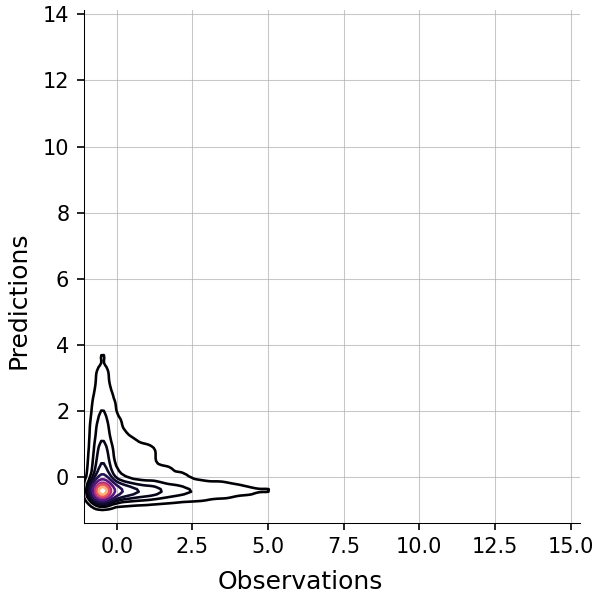

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(4,4), constrained_layout=True)
y = hstack([y.numpy() for (x,y) in te])
p = squeeze(dense.predict(te, verbose=0))
seaborn.kdeplot(x=y, y=p, cmap='magma', ax=ax)
fig.supxlabel('Observations')
fig.supylabel('Predictions');

This is not great. With a good model, we expect clustering around the line where predictions=observations. Instead we have a very dense hotspot around the lowest value with residual tails reaching in both directions. This is because, as we observed in the histograms above, most of our precipitation labels corresponde to no/little rain. The model is optimizing for those low values and missing a lot of rain events.

Below, we try another approach: using a binary classifier where 0 corresponds to low precip and 1 corresponds to high precip.

### Alternative: Binary Precipitation Classification

We have to pick a precipitation threshold for binary classfication. Below the threshold, everything is considered "llow precipitation" and above it everything is "high precipitation." The plot below shows the ECDF of the precipitation labels with an interactive slider (when running the notebook) to see the location of various quantiles.

<IPython.core.display.Javascript object>


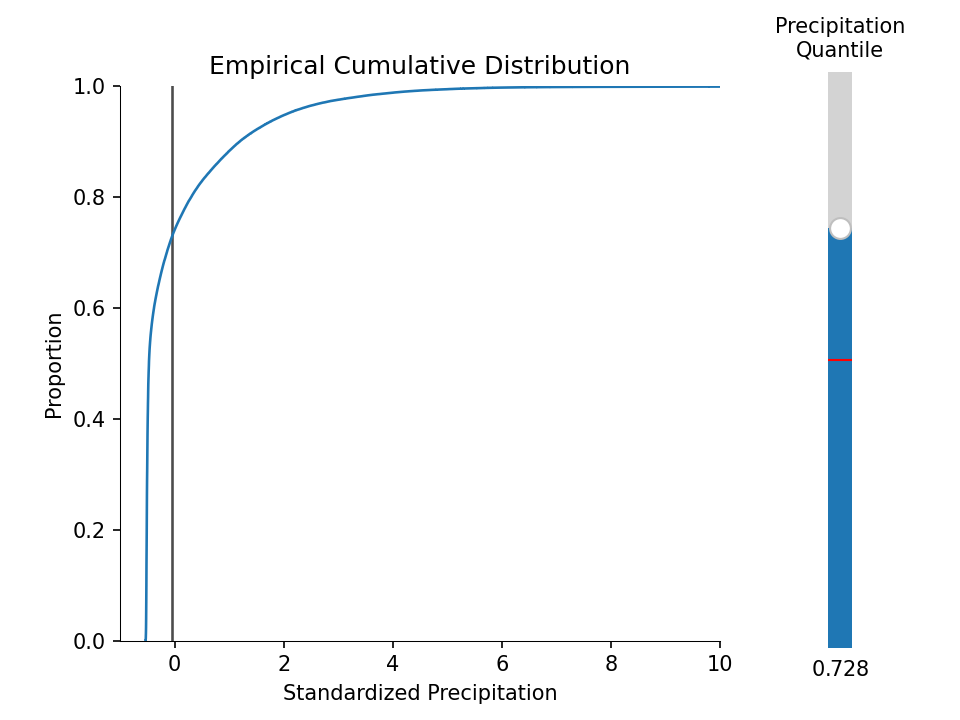

In [44]:
fig, ax = plt.subplots(1, 1)
seaborn.ecdfplot(P, ax=ax)
line = ax.axvline(quantile(P, 0.5), color='k', alpha=0.7, zorder=-1)
ax.set_xlabel("Standardized Precipitation")
ax.set_title("Empirical Cumulative Distribution")
ax.set_xlim(-1, 10)
ax.grid(False)
plt.subplots_adjust(right=0.75)

axsl = plt.axes([0.85, 0.1, 0.05, 0.8])
slider = Slider(
    ax=axsl,
    label='Precipitation\nQuantile',
    valmin=0,
    valmax=1,
    valinit=0.5,
    orientation='vertical'
)
def update_slider(q):
    x = quantile(P, q)
    line.set_xdata([x,x])
    fig.canvas.draw_idle()
slider.on_changed(update_slider);

The ECDF demonstrates that >50 % of the labels represent little/no precipitation. We could pick a threshold based on physical precipitation units, but because this is just a toy example, I'll use the 50th percentile. This means half of the classification labels will be 0 and the other half will be 1.

In [45]:
#create integer labels with 0=low precip and 1=high precip
b = zeros(len(P), dtype=uint8)
b[P > quantile(P, 0.5)] = 1

In [46]:
#tensorize and shuffle the temperature data set
ds = Dataset.from_tensor_slices((inputs, b)).shuffle(len(b))

In [47]:
#training, validation, and test splits
n = len(P)//10
tr = ds.take(7*n).batch(64)
va = ds.skip(7*n).take(2*n).batch(64)
te = ds.skip(9*n).batch(64)

#### Dense Model

This model furnishes the probability estimate directly, not a logit.

In [48]:
dense_binary = Sequential([
    Flatten(),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1),
    Activation('sigmoid')
])

In [49]:
compile_model(dense_binary, BinaryCrossentropy(from_logits=False), metrics=[metrics.BinaryAccuracy(threshold=0.5)])

In [50]:
history, test_loss = fit_model(dense_binary, tr, va, te, 10, 0);

In [51]:
_, val_accuracy = dense_binary.evaluate(va, verbose=False)
print('dense model validation accuracy:', val_accuracy)
_, test_accuracy = dense_binary.evaluate(te, verbose=False)
print('dense model test accuracy:      ', test_accuracy)

dense model validation accuracy: 0.9134708642959595
dense model test accuracy:       0.9108894467353821


Not too shabby. The model achieves 91 % accuracy in predicting low/high precipitation over a two day window.

# Conclusion

To summarize quickly, we created a fairly accurate 2 day temperature forecast using a convolutional neural network. Then we created a useful, although not perfect, binary predictor for whether the next two days are likely to be dry or wet. For both models we used downsampled and smoothed data from 155 weather stations in the Austrian Alps which are part of the WegenerNet project.

This was just an interesting practice project and there are lots of other things one could do. Recurrant models for the temperature forecast would be one obvious next step. I think it would also be interesting to try the precipitation classifier with more than 2 categories. For example, one could choose quantiles representing dry, mostly dry, probably wet, and definitely wet. An easy way to do that would be simply dividing the records into quartiles.